In [1]:
import torch
torch.__version__

'0.3.0.post4'

# Assignment 1

Fill in the code and then print to PDF to send for marking.

## A first look at PyTorch


We will now take a look at a first concrete example of a neural network, which makes use of the Python library PyTorch to learn to classify fashion articles. Unless you already have experience with PyTorch or similar libraries, you will not understand everything about this first example right away. You probably haven't even installed Pytorch yet. Don't worry, that is perfectly fine. We will do all that below.

The problem we are trying to solve here is to classify grayscale images of fashion articles (28 pixels by 28 pixels), into their 10 categories. The dataset we will use is the Fashion-MNIST dataset, a dropin replacement of MNIST which is a classic dataset in the machine learning community, which has been around for almost as long as the field itself and has been very intensively studied. It's a set of 60,000 training images, plus 10,000 test images. You can think of "solving" Fashion-MNIST or MNIST as the "Hello World" of deep learning --- it's what you do to verify that your algorithms are working as expected. As you become a machine learning practitioner, you will see MNIST come up over and over again, in scientific papers, blog posts, and so on.

The Fashion-MNIST and MNIST datasets comes as standard datasets in PyTorch's `torchvision` library, as subclasses of `torch.utils.data.Dataset` which makes it convinent to use as we will see.

Our images are encoded as `PIL.Image.Image` objects, and the labels are simply an array of integers, ranging from 0 to 9.  There is a one-to-one correspondence between the images and the labels.

Before training, we will transform our data by first converting it to a `Tensor` and then  normalizing it so that all image values have mean 0.5 and standard deviation of 1, by composing these operations as `transforms` function to the datasets:

In [2]:
from torchvision import datasets, transforms

trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])

train_dataset = datasets.FashionMNIST('data', transform=trans, train=True, download=True)
test_dataset = datasets.FashionMNIST('data', transform=trans, train=False, download=True)

Processing...
Done!


`train_dataset` forms the "training set", the data that the model will learn from. The model will then be tested on the "test set", `test_dataset`. 

Let's have a look at the training data:

In [3]:
len(train_dataset)

60000

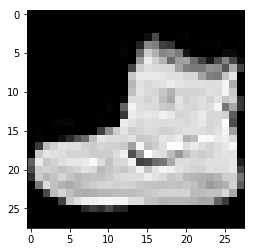

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(train_dataset.train_data[0], cmap='gray')

In [1]:
train_dataset.train_labels[0]

NameError: name 'train_dataset' is not defined

In [ ]:
train_dataset.train_data[0]

Let's have a look at the test data:

In [6]:
len(test_dataset)

10000

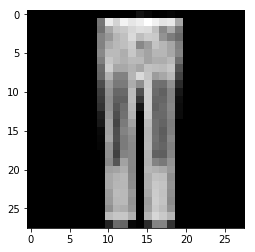

In [7]:
plt.imshow(test_dataset.test_data[15], cmap='gray')

In [8]:
test_dataset.test_labels[15]

1

Our workflow will be as follow: first we will present our neural network with the training data, `train_dataset` via the `DataLoader` iterator. The network will then learn to associate images and labels. Finally, we will ask the network to produce predictions for `test_dataset`, and we will verify if these predictions match the test labels.

Let's build our network --- again, remember that you aren't supposed to understand everything about this example just yet.

In [9]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x)

In [10]:
model = Net()
if torch.cuda.is_available():
    model.cuda()

The core building block of neural networks is the "layer", a data-processing module which you can conceive as a "filter" for data. Some data comes in, and comes out in a more useful form. Precisely, layers extract _representations_ out of the data fed into them --- hopefully  representations that are more meaningful for the problem at hand. Most of deep learning really consists of chaining together simple layers  which will implement a form of progressive "data distillation". A deep learning model is like a sieve for data processing, made of a  succession of increasingly refined data filters --- the "layers".

Here our network consists of a sequence of two `Linear` layers, which are densely-connected (also called "fully-connected") neural layers.  The output (and last) layer is a 10-way "softmax" layer, which means it will return an array of 10 probability scores (summing to 1). Each  score will be the probability that the current article image belongs to one of our 10 classes.

To make our network ready for training, we need to pick three more things:

* An optimizer: this is the mechanism through which the network will update itself based on the data it sees and its loss function.
* A loss function: the is how the network will be able to measure how good a job it is doing on its training data, and thus how it will be  able to steer itself in the right direction.
* Metrics to monitor during training and testing. Here we will only care about accuracy (the fraction of the images that were correctly classified).

The exact purpose of the loss function and the optimizer will be made clear throughout the next lectures and homeworks. Lets start with the optimizer:

In [11]:
import torch.optim as optim

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [12]:
kwargs = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=128, 
                                           shuffle=True,
                                           **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=128,
                                          shuffle=False,
                                          **kwargs)

We are now ready to train our network, meaning, we "fit" the model to its training data, which in PyTorch is done via a `train()`  helper which typically contains the loss we wish to minimize and looks like this: 

In [13]:
from torch.autograd import Variable

def train(epoch):
    model.train()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)

        optimizer.zero_grad()
        
        output = model(data)
        
        loss = F.nll_loss(output, target)
        loss.backward()
        
        optimizer.step()
        
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))

The quantity being displayed during training in the above helper is: the "loss" of the network over the training data. Let us write a `test()` helper which will print out the accuracy metric of the network over the test data:

In [14]:
def test():
    model.eval()
    
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target, size_average=False).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

Now let us  train the network for 5 epochs and print the test set accuracy at the end of each epoch:

In [15]:
for epoch in range(1, 5 + 1):
    train(epoch)
    test()

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.312649
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.203849
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.102406
Train Epoch: 1 [3840/60000 (6%)]	Loss: 1.968619
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.863094
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.719783
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.655484
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.581791
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.470022
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.434871
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.255092
Train Epoch: 1 [14080/60000 (23%)]	Loss: 1.194115
Train Epoch: 1 [15360/60000 (26%)]	Loss: 1.329170
Train Epoch: 1 [16640/60000 (28%)]	Loss: 1.167275
Train Epoch: 1 [17920/60000 (30%)]	Loss: 1.015199
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.085723
Train Epoch: 1 [20480/60000 (34%)]	Loss: 1.036617
Train Epoch: 1 [21760/60000 (36%)]	Loss: 1.079313
Train Epoch: 1 [23040/60000 (38%)]	Loss: 0.888740
Train Epoch: 1 [24320/60000 (41%)]	Loss: 0.962205
Train Epoch: 1 [

Train Epoch: 4 [28160/60000 (47%)]	Loss: 0.520870
Train Epoch: 4 [29440/60000 (49%)]	Loss: 0.487541
Train Epoch: 4 [30720/60000 (51%)]	Loss: 0.401477
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.516928
Train Epoch: 4 [33280/60000 (55%)]	Loss: 0.605887
Train Epoch: 4 [34560/60000 (58%)]	Loss: 0.584341
Train Epoch: 4 [35840/60000 (60%)]	Loss: 0.521096
Train Epoch: 4 [37120/60000 (62%)]	Loss: 0.509951
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.420728
Train Epoch: 4 [39680/60000 (66%)]	Loss: 0.495663
Train Epoch: 4 [40960/60000 (68%)]	Loss: 0.470801
Train Epoch: 4 [42240/60000 (70%)]	Loss: 0.557294
Train Epoch: 4 [43520/60000 (72%)]	Loss: 0.459838
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.480527
Train Epoch: 4 [46080/60000 (77%)]	Loss: 0.408365
Train Epoch: 4 [47360/60000 (79%)]	Loss: 0.540321
Train Epoch: 4 [48640/60000 (81%)]	Loss: 0.429234
Train Epoch: 4 [49920/60000 (83%)]	Loss: 0.563185
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.489698
Train Epoch: 4 [52480/60000 (87%)]	Loss: 0.565026


Our test set accuracy turns out to be 84% --- that's quite a bit lower than the training set accuracy.  This gap between training accuracy and test accuracy is an example of "overfitting",  the fact that machine learning models tend to perform worse on new data than on their training data.  Overfitting will be a central topic in machine learning and deep learning in particular.

This concludes our very first example --- you just saw how we could build and a train a neural network to classify clothing articles, in less than 30 or so lines of Python code.

## Assignment

In this assignment we will try to get some intuition on the hyperparameters associated with the optimizer. Optimization hyperparameters have a large influence on the quality of solutions found by optimization
algorithms for deep neural networks. The optimization algorithms we will look at have many hyperparameters:

* $\alpha_0$ the initial step size
* the step decay scheme
* $\beta_0$ the initial momentum value
* the momentum schedule
* ...

In this assignment we will concentrate on the the step size and the step decay scheme.

### Fixed Model

We will work with the following fixed model for the CIFAR-10 data:

In [127]:
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']
}

class VGG11(nn.Module):
    def __init__(self):
        super(VGG11, self).__init__()
        self.features = self._make_layers(cfg['VGG11'])
        self.classifier = nn.Linear(512, 10)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)
    
    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)

In [128]:
model = VGG11()
if torch.cuda.is_available():
    model.cuda()

### Task 1

Load the CIFAR-10 dataset with some appropriate `batch_size` and transform it to a `Tensor` and normalize it using:

In [59]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
transform = transforms.Compose(
    [transforms.ToTensor(),
     normalize])

In [82]:
### YOUR CODE HERE ###

CIFAR_train = datasets.CIFAR10('data',download=True, transform=transform, train=True)
CIFAR_test = datasets.CIFAR10('data',download=True, transform=transform, train=False)

Files already downloaded and verified
Files already downloaded and verified


In [107]:
kwargs = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {'num_workers': 16}
train_loader = torch.utils.data.DataLoader(CIFAR_train,
                                           batch_size=32, 
                                           shuffle=False,
                                           sampler=torch.utils.data.sampler.SubsetRandomSampler(list(range(4*1024))),
                                           **kwargs)
test_loader = torch.utils.data.DataLoader(CIFAR_test,
                                          batch_size=16,
                                          shuffle=False,
                                          sampler=torch.utils.data.sampler.SubsetRandomSampler(list(range(2*128))),
                                          **kwargs)

TypeError: __init__() missing 2 required positional arguments: 'batch_size' and 'drop_last'

### Task 2

Next we want to train the network by minimizing the `CrossEntropyLoss` for `50` epochs using the `SGD` and `Adam` optimizer using their default parameters and plot the validation accuracy and test accuracy over the course of the training.

In [102]:
optimizer = optim.Adam(model.parameters(),lr=0.001)
criterion = nn.CrossEntropyLoss()
def train(epoch):
    model.train()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)

        optimizer.zero_grad()
        
        output = model(data)
        
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), 4*1024,
                100. * batch_idx / len(train_loader), loss.data[0]))
            
def test():
    model.eval()
    
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += criterion(output, target).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, 2*128,
        100. * correct / 2*128))

In [104]:
optimizer = optim.Adam(model.parameters(),lr=0.001)
criterion = nn.CrossEntropyLoss()

for epoch in range(1, 5 + 1):
    train(epoch)
    test()

Train Epoch: 1 [0/4096 (0%)]	Loss: 2.219313
Train Epoch: 1 [320/4096 (8%)]	Loss: 1.476289
Train Epoch: 1 [640/4096 (16%)]	Loss: 2.025711
Train Epoch: 1 [960/4096 (23%)]	Loss: 1.690868
Train Epoch: 1 [1280/4096 (31%)]	Loss: 1.423154
Train Epoch: 1 [1600/4096 (39%)]	Loss: 2.141390
Train Epoch: 1 [1920/4096 (47%)]	Loss: 1.581337
Train Epoch: 1 [2240/4096 (55%)]	Loss: 2.227865
Train Epoch: 1 [2560/4096 (62%)]	Loss: 1.602215
Train Epoch: 1 [2880/4096 (70%)]	Loss: 1.484336
Train Epoch: 1 [3200/4096 (78%)]	Loss: 2.034958
Train Epoch: 1 [3520/4096 (86%)]	Loss: 1.617825
Train Epoch: 1 [3840/4096 (94%)]	Loss: 1.420125

Test set: Average loss: 0.0028, Accuracy: 102/10000 (652800%)

Train Epoch: 2 [0/4096 (0%)]	Loss: 1.454084
Train Epoch: 2 [320/4096 (8%)]	Loss: 1.364363
Train Epoch: 2 [640/4096 (16%)]	Loss: 1.161226
Train Epoch: 2 [960/4096 (23%)]	Loss: 2.079358
Train Epoch: 2 [1280/4096 (31%)]	Loss: 1.809796
Train Epoch: 2 [1600/4096 (39%)]	Loss: 1.366488
Train Epoch: 2 [1920/4096 (47%)]	Loss: 1

In [108]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
criterion = nn.CrossEntropyLoss()

for epoch in range(1, 5 + 1):
    train(epoch)
    test()

Train Epoch: 1 [0/4096 (0%)]	Loss: 1.061143
Train Epoch: 1 [320/4096 (8%)]	Loss: 15.219403
Train Epoch: 1 [640/4096 (16%)]	Loss: 25.253990
Train Epoch: 1 [960/4096 (23%)]	Loss: 22.465025
Train Epoch: 1 [1280/4096 (31%)]	Loss: 22.064503
Train Epoch: 1 [1600/4096 (39%)]	Loss: 10.278015
Train Epoch: 1 [1920/4096 (47%)]	Loss: 13.989035
Train Epoch: 1 [2240/4096 (55%)]	Loss: 16.387102
Train Epoch: 1 [2560/4096 (62%)]	Loss: 10.798111
Train Epoch: 1 [2880/4096 (70%)]	Loss: 10.702368
Train Epoch: 1 [3200/4096 (78%)]	Loss: 12.500554
Train Epoch: 1 [3520/4096 (86%)]	Loss: 3.188299
Train Epoch: 1 [3840/4096 (94%)]	Loss: 5.369475

Test set: Average loss: 0.0065, Accuracy: 105/10000 (672000%)

Train Epoch: 2 [0/4096 (0%)]	Loss: 3.493046
Train Epoch: 2 [320/4096 (8%)]	Loss: 10.130626
Train Epoch: 2 [640/4096 (16%)]	Loss: 6.760785
Train Epoch: 2 [960/4096 (23%)]	Loss: 8.780539
Train Epoch: 2 [1280/4096 (31%)]	Loss: 4.866037
Train Epoch: 2 [1600/4096 (39%)]	Loss: 5.329214
Train Epoch: 2 [1920/4096 (47

Process Process-776:
Process Process-772:
Process Process-771:
Process Process-775:
Process Process-774:
Process Process-770:
Process Process-767:
Process Process-765:
Process Process-778:
Process Process-768:
Process Process-780:
Process Process-769:
Process Process-766:
Process Process-777:
Process Process-779:
Process Process-773:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/multiprocessing/process.py", line 254, in _bootstrap
    self.run()

  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 36, in _worker_loop
    r = index_queue.get()
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/multiprocessing/queues.py", line 342, in get
    with self._rlock:
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 36, in _worker_loop
    r = index_queue.get()
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 36, in _worker_loop
    r = index_queue.get()
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/multiprocessing/queues.py", line 342, in get
    with self._rlock:
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/multiprocessing/queues.py", line 342, in get
    with self._rlock:
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/m

KeyboardInterrupt: 

## Task 3

Now implement decaying the learning rate using the `ReduceLROnPlateau` scheme in your training with $\delta=0.9$ and plot the validation and test accuracy over the course of the training using the `SGD` and `Adam` optimizer. You will need to lookup the PyTorch API to figure out how to use this scheme.

In [130]:
n_train = 1024
n_test = int(n_train * 0.125)

kwargs = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {'num_workers': 16}
train_loader = torch.utils.data.DataLoader(CIFAR_train,
                                           batch_size=8,
                                           shuffle=False,
                                           sampler=torch.utils.data.sampler.SubsetRandomSampler(list(range(n_train))),
                                           **kwargs)
test_loader = torch.utils.data.DataLoader(CIFAR_test,
                                          batch_size=8,
                                          shuffle=False,
                                          sampler=torch.utils.data.sampler.SubsetRandomSampler(list(range(n_test))),
                                          **kwargs)

In [131]:
optimizer = optim.Adam(model.parameters(),lr=0.002)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor=0.9)

def train(epoch):
    model.train()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)

        optimizer.zero_grad()
        
        output = model(data)
        
        loss = criterion(output, target)
        loss.backward()

        optimizer.step()
        
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), n_train,
                100. * batch_idx / len(train_loader), loss.data[0]))
            
def test():
    model.eval()
    
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += criterion(output, target).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, n_test,
        100. * correct / n_test))
    return test_loss

for epoch in range(1, 5 + 1):
    train(epoch)
    loss = test()
    scheduler.step(loss)

Train Epoch: 1 [0/1024 (0%)]	Loss: 2.223039
Train Epoch: 1 [80/1024 (8%)]	Loss: 2.511935
Train Epoch: 1 [160/1024 (16%)]	Loss: 2.411312
Train Epoch: 1 [240/1024 (23%)]	Loss: 2.328630
Train Epoch: 1 [320/1024 (31%)]	Loss: 2.163109
Train Epoch: 1 [400/1024 (39%)]	Loss: 2.613144
Train Epoch: 1 [480/1024 (47%)]	Loss: 2.507614
Train Epoch: 1 [560/1024 (55%)]	Loss: 1.971611
Train Epoch: 1 [640/1024 (62%)]	Loss: 1.903465
Train Epoch: 1 [720/1024 (70%)]	Loss: 2.195800
Train Epoch: 1 [800/1024 (78%)]	Loss: 2.130899
Train Epoch: 1 [880/1024 (86%)]	Loss: 1.743505
Train Epoch: 1 [960/1024 (94%)]	Loss: 2.262308

Test set: Average loss: 0.0034, Accuracy: 41/128 (32%)

Train Epoch: 2 [0/1024 (0%)]	Loss: 2.181853
Train Epoch: 2 [80/1024 (8%)]	Loss: 2.318113
Train Epoch: 2 [160/1024 (16%)]	Loss: 1.818876
Train Epoch: 2 [240/1024 (23%)]	Loss: 2.216980
Train Epoch: 2 [320/1024 (31%)]	Loss: 2.124729
Train Epoch: 2 [400/1024 (39%)]	Loss: 2.010461
Train Epoch: 2 [480/1024 (47%)]	Loss: 2.066502
Train Epoch: 

### Task 4

Finally we want to tune the initial step size or  learning rate for the `SGD` and `Adam` for the setup we have till now. 

One strategy is to distribute different learning rates between your fellow classmates and then communicate the best result and refine the learning rate this way till you collectively find the best parameter. This will require some coordination and communication which is what I actually want you do to. Some of your classmates will be confused or stuck, help them! Perhaps you will see some neat helper or good code abstraction, learn from it and apply it to your own code.

Finally, plot the validation accuracy and test accuracy over the course of training for the best learning rate you found for both `SGD` and `Adam`.

In [78]:
### YOUR CODE HERE ###